In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

root = '/content/drive/MyDrive/instacart-data/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_pickle(root + 'Finaldata.pkl')
print(df.shape)
df.head()

(8474661, 69)


,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,...,41,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504
1,1,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,41,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504
3,1,12427,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,...,41,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504
4,1,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,...,41,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504


### Memory Reduction

In [ ]:
def shrink_memory(df):

  """
    It tries to reduce the memory usage of the dataframe
    Parameters: Dataframe
    Return: Dataframe
    """
  start_mem_usg = df.memory_usage().sum() / 1024**3
  print("Memory usage of orignal data is :", round(start_mem_usg , 2)," GB")
  for col in df.columns:
      if df[col].dtypes in ["int64", "int32", "int16"]:

          cmin = df[col].min()
          cmax = df[col].max()

          if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
              df[col] = df[col].astype(np.int8)

          elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
              df[col] = df[col].astype(np.int16)

          elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
              df[col] = df[col].astype(np.int32)

      if df[col].dtypes in ["float64", "float32"]:

          cmin = df[col].min()
          cmax = df[col].max()

          if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
              df[col] = df[col].astype(np.float16)
          # elif cmin > np.finfo(np.float8).min and cmax < np.finfo(np.float8).max:
          #     df[col] = df[col].astype(np.float8)
          elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
              df[col] = df[col].astype(np.float32)


  print("")
  print("Memory after reduction without loss in precision")
  mem_usg = df.memory_usage().sum() / 1024**3
  print("Memory usage is: ",round(mem_usg , 2)," GB")
  print("This is ",100* round(mem_usg/start_mem_usg , 2),"% of the initial size")

  return df

In [ ]:
df = shrink_memory(df)


Memory usage of orignal data is : 1.51  GB

Memory after reduction without loss in precision
Memory usage is:  1.18  GB
This is  78.0 % of the initial size


In [ ]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [ ]:
df.head()


,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [ ]:
label = 'reordered'
x_cols = df.columns.drop('reordered')


In [ ]:
X = df[x_cols]
y = df[label]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [ ]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])


10.0

In [ ]:
y_test.value_counts()


,count
reordered,
0.0,1911460
1.0,207206


In [ ]:
# freeing memory
del df, X, y
gc.collect()

0

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
input_dim =  X_train_sc.shape[1]
input_dim

67

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from tensorflow.keras.callbacks import History


def recall_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [ ]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()

model.add(Dense(units = 64, activation = 'relu', input_dim = input_dim))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation ='sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,465 (21.35 KB)

 Trainable params: 5,465 (21.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train


In [ ]:
history = model.fit(
    X_train_sc, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.15,
    verbose=1,
    class_weight={0: 1, 1: 10},
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience= 3, verbose=0, mode='auto')]
)


Epoch 1/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.7222 - loss: 0.9728 - val_accuracy: 0.7342 - val_loss: 0.5244
Epoch 2/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7329 - loss: 0.9527 - val_accuracy: 0.7361 - val_loss: 0.5163
Epoch 3/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7359 - loss: 0.9505 - val_accuracy: 0.7297 - val_loss: 0.5309
Epoch 4/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7366 - loss: 0.9479 - val_accuracy: 0.7590 - val_loss: 0.4987
Epoch 5/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7373 - loss: 0.9458 - val_accuracy: 0.7393 - val_loss: 0.5210
Epoch 6/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7362 - loss: 0.9467 - val_accuracy: 0.7446 - val_loss: 0.5199
Epoch 7/10
10552/10552 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7374 - loss: 0.9449 - val_accuracy: 0.7501 - val_loss: 0.5052


Text(0.5, 1.0, 'Loss')

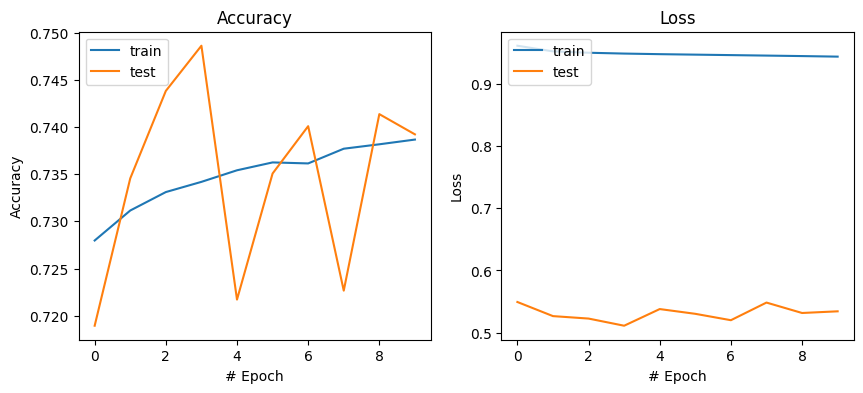

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_title('Loss')

66209/66209 ━━━━━━━━━━━━━━━━━━━━ 70s 1ms/step

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.84   1911460
         1.0       0.25      0.76      0.37    207206

    accuracy                           0.75   2118666
   macro avg       0.61      0.75      0.61   2118666
weighted avg       0.90      0.75      0.80   2118666

Accuracy   Score :  0.7492384358837118
F1 Score:  0.3709565892794559
Area under curve :  0.8321141980007808 



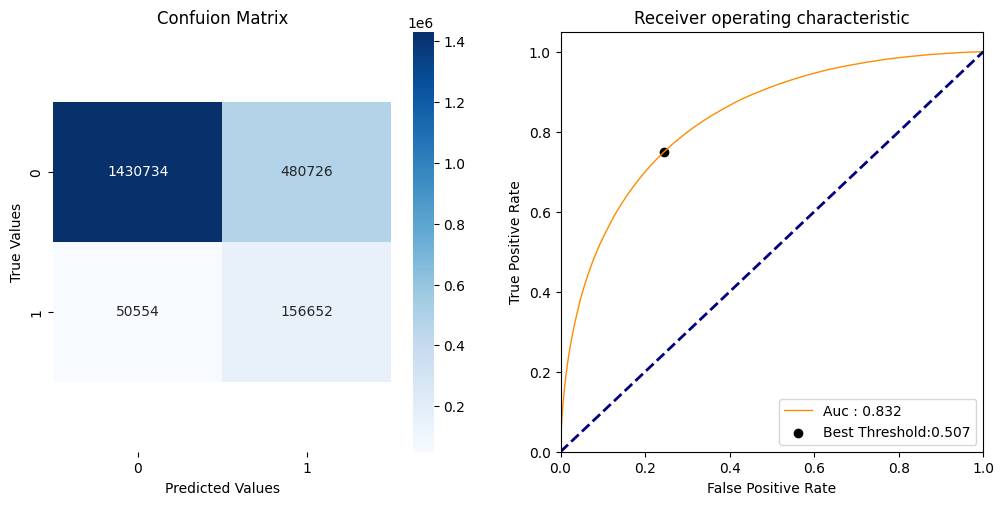

In [ ]:
probabilities = model.predict(X_test_sc)
predictions = (probabilities > 0.5).astype(int)

print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probabilities)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()